In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [2]:
# === 0) Imports ===
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# === 1) Load and tidy ===
# Expecting columns like below (your example):
# Year,Week,Resort,Visitors,State,
# avg Maximum temperature (Degree C), avg Minimum temperature (Degree C), sum Rainfall amount (millimetres)
df = pd.read_csv("../data/merged/merged_data.csv")

df = df.drop(columns=["Visitors"])

In [4]:
# Rename to convenient snake_case
rename_cols = {
    "Maximum temperature (Degree C)": "avg_max_temp",
    "Minimum temperature (Degree C)": "avg_min_temp",
    "Rainfall amount (millimetres)": "sum_precip",
}
df = df.rename(columns=rename_cols)

# Ensure sorted order (important for time series)
df = df.sort_values(["Resort", "Year", "Week"]).reset_index(drop=True)

# Optional: restrict to the years you want to train on (2014..2024)
# (If your file includes 2025 partials and you don't want to use them)
df_train = df[(df["Year"] >= 2014) & (df["Year"] <= 2024)].copy()

# === 2) Helpers ===
def make_week_index(x: pd.DataFrame) -> pd.Series:
    """
    Create a strictly increasing integer index per resort by Year/Week (1..15 per year).
    """
    # For SARIMAX we just need a regular integer index; temporal spacing is regular by construction
    return pd.RangeIndex(start=0, stop=len(x), step=1)

def fit_sarima_best(series: pd.Series,
                    seasonal_period: int = 15,
                    order_grid=((1,1,1),(2,1,1),(1,1,0)),
                    seasonal_grid=((1,1,1),(0,1,1))):
    """
    Small AIC grid search over SARIMA to get a reasonable model fast.
    series: 1D pandas Series indexed by a simple increasing index.
    """
    best_aic = np.inf
    best_res = None
    best_cfg = None

    for (p,d,q) in order_grid:
        for (P,D,Q) in seasonal_grid:
            try:
                model = SARIMAX(
                    series,
                    order=(p,d,q),
                    seasonal_order=(P,D,Q, seasonal_period),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                res = model.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_res = res
                    best_cfg = ((p,d,q), (P,D,Q, seasonal_period))
            except Exception:
                continue
    return best_res, best_cfg, best_aic

def forecast_series(series: pd.Series, steps: int, log_transform: bool = False):
    """
    Fit a SARIMA with small grid search and forecast.
    If log_transform=True, uses log1p/expmp1 to keep predictions >= 0 (useful for precipitation).
    """
    # Handle missing values with simple interpolation (keeps weekly cadence)
    s = series.copy()
    if log_transform:
        s = np.log1p(s.clip(lower=0))  # avoid negatives before log
    s = s.interpolate(limit_direction="both")

    res, cfg, aic = fit_sarima_best(s)

    fc = res.get_forecast(steps=steps)
    yhat = fc.predicted_mean

    # Back-transform if needed
    if log_transform:
        yhat = np.expm1(yhat)
        # Ensure no tiny negative due to numeric jitter
        yhat = yhat.clip(lower=0)

    return yhat, cfg, aic

# === 3) Run forecasts per (Resort × Feature) ===
resorts = df_train["Resort"].unique()
weeks = list(range(1,16))  # Weeks 1..15

# Storage for each feature's 2026 forecast
out_rows = []

for resort in resorts:
    # Filter resort block
    block = df_train[df_train["Resort"] == resort].copy()

    # Build simple integer time index
    block = block.sort_values(["Year","Week"]).reset_index(drop=True)
    block.index = make_week_index(block)

    # 3 features to forecast
    features = [
        ("avg_max_temp", False),  # temperatures: raw scale
        ("avg_min_temp", False),
        ("sum_precip", True),     # precip: log-transform to avoid negatives
    ]

    # Fit & forecast each feature 15 steps (2026 season)
    preds = {}
    for feat, use_log in features:
        series = block[feat].astype(float)
        yhat, cfg, aic = forecast_series(series, steps=15, log_transform=use_log)
        preds[feat] = yhat.values  # numpy array length 15

    # Assemble rows for this resort
    for w_idx, w in enumerate(weeks):
        out_rows.append({
            "Year": 2026,
            "Week": w,
            "Resort": resort,
            "avg_max_temp": preds["avg_max_temp"][w_idx],
            "avg_min_temp": preds["avg_min_temp"][w_idx],
            "sum_precip": preds["sum_precip"][w_idx],
        })

future_2026 = pd.DataFrame(out_rows, columns=[
    "Year","Week","Resort","avg_max_temp","avg_min_temp","sum_precip"
])

# === 4) (Optional) quick sanity clipping for extreme values ===
# temperatures in plausible alpine winter ranges; adjust if needed
future_2026["avg_max_temp"] = future_2026["avg_max_temp"].clip(lower=-10, upper=10)
future_2026["avg_min_temp"] = future_2026["avg_min_temp"].clip(lower=-15, upper=5)
future_2026["sum_precip"]   = future_2026["sum_precip"].clip(lower=0)

# === 5) Save ===
future_2026 = future_2026.sort_values(["Resort","Week"]).reset_index(drop=True)
future_2026.to_csv("weekly_climate_2026.csv", index=False)
print("Saved weekly_climate_2026.csv")
future_2026.head()


c:\Users\Suman\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Suman\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Saved weekly_climate_2026.csv


,Year,Week,Resort,avg_max_temp,avg_min_temp,sum_precip
0,2026,1,Charlotte Pass,2.541126,-2.107635,257.201342
1,2026,2,Charlotte Pass,1.461610,-3.446841,212.322199
2,2026,3,Charlotte Pass,1.380987,-3.530767,162.092900
3,2026,4,Charlotte Pass,1.659358,-2.893337,164.693589
4,2026,5,Charlotte Pass,1.535985,-3.145986,158.966315


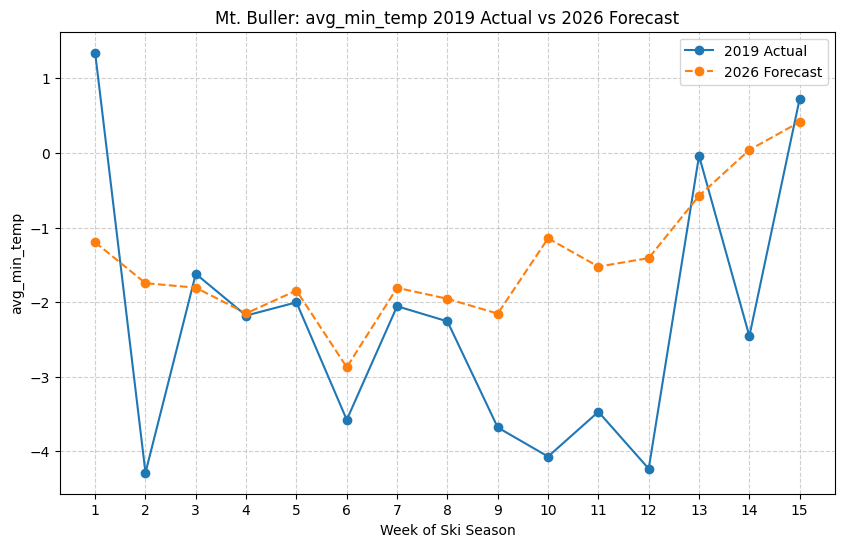

In [5]:
import matplotlib.pyplot as plt

resort_viz = "Mt. Buller"
features_viz = "avg_min_temp"
year_viz = 2019

# Filter Mount Buller 2024 from original training dataset
buller_2024 = df_train[(df_train["Resort"]==resort_viz) & (df_train["Year"]==year_viz)]

# Filter Mount Buller 2026 forecast
buller_2026 = future_2026[(future_2026["Resort"]==resort_viz) & (future_2026["Year"]==2026)]

plt.figure(figsize=(10,6))
plt.plot(buller_2024["Week"], buller_2024[features_viz], marker="o", label=str(year_viz)+" Actual")
plt.plot(buller_2026["Week"], buller_2026[features_viz], marker="o", linestyle="--", label="2026 Forecast")

plt.xticks(range(1,16))
plt.xlabel("Week of Ski Season")
plt.ylabel(features_viz)
plt.title(resort_viz + ": " +features_viz+ " " + str(year_viz)+" Actual vs 2026 Forecast")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


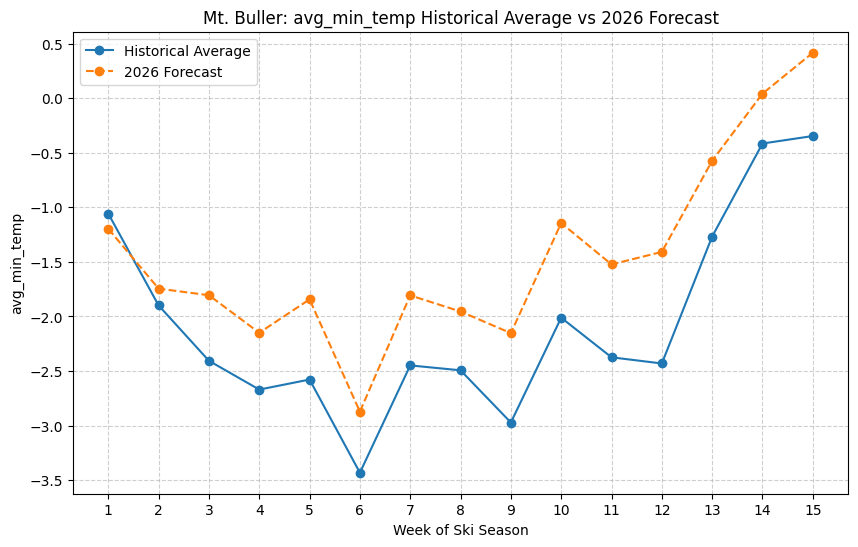

In [6]:
import matplotlib.pyplot as plt

resort_viz = "Mt. Buller"
features_viz = "avg_min_temp"

# Filter Mount Buller from training dataset and calculate average across all years
buller_historical = df_train[df_train["Resort"]==resort_viz].groupby("Week")[features_viz].mean()

# Filter Mount Buller 2026 forecast
buller_2026 = future_2026[(future_2026["Resort"]==resort_viz) & (future_2026["Year"]==2026)]

plt.figure(figsize=(10,6))
plt.plot(buller_historical.index, buller_historical.values, marker="o", label="Historical Average")
plt.plot(buller_2026["Week"], buller_2026[features_viz], marker="o", linestyle="--", label="2026 Forecast")

plt.xticks(range(1,16))
plt.xlabel("Week of Ski Season")
plt.ylabel(features_viz)
plt.title(f"{resort_viz}: {features_viz} Historical Average vs 2026 Forecast")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()